In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import nltk
%matplotlib inline

In [6]:
df_train=pd.read_csv('/mnt/quora_kaggle/train.csv')
df_train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [7]:
df_test=pd.read_csv('/mnt/quora_kaggle/test.csv')

In [8]:

#Counter(data.is_duplicate)

In [9]:
#word share: common words in both questions
def word_share(row):
    try:
        question1=row['question1'].lower().split()
        question2=row['question2'].lower().split()
        common=np.intersect1d(question1,question2)
    except:
        # ('error in',row)
        return 0
    return 2*len(common)/(len(question1)+len(question1))

In [11]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [14]:
import time
t=time.time()
match_list=df_train.apply(word_share, axis=1, raw=True)
print(time.time()-t)

30.062744140625


In [13]:
'''
plt.figure(figsize=(15, 5))
#train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(match_list_share[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(match_list_share[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
''''''

NameError: name 'match_list_share' is not defined

In [16]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

In [17]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [18]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


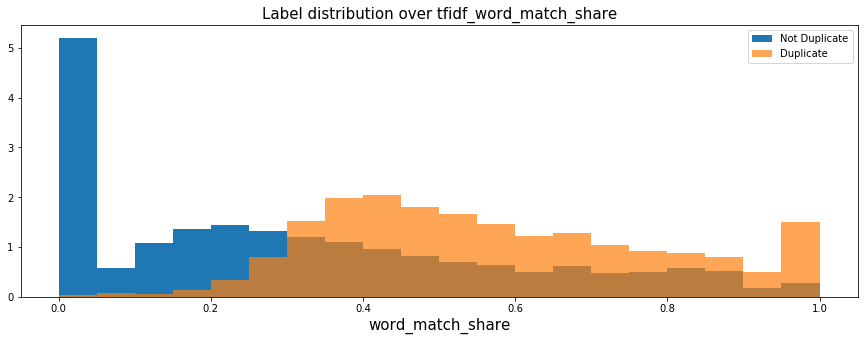

In [19]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [20]:
'''
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
print('gidi AUC:', roc_auc_score(df_train['is_duplicate'], match_list))
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], match_list_share))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-20-ee56305c565a>, line 6)

In [ ]:
'''
print('gidi logloss:', log_loss(df_train['is_duplicate'], match_list))
print('Original logloss:', log_loss(df_train['is_duplicate'], match_list_share))
print('   TFIDF logloss:', log_loss(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

In [ ]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_share'] = match_list
x_train['word_match'] = match_list_share
x_train['tfidf_word_match'] = tfidf_train_word_match

x_test['word_share'] =df_test.apply(word_share, axis=1, raw=True)
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

In [ ]:
pos_train=x_train[y_train==1]
neg_train=x_train[y_train==0]
p=0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1


In [ ]:
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1

In [ ]:
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])

In [ ]:
print(len(pos_train) / (len(pos_train) + len(neg_train)))

In [ ]:
x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

In [ ]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

In [ ]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False, float_format='%.4f')